In [9]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

In [5]:
def run_kalman_filter_and_predict(batch_positions):
    """
    Applies Kalman Filter to the first 5 timesteps to predict the next 10 timesteps.
    
    Args:
        batch_positions: A numpy array of shape (batch_size, 15, 3)
                         containing the 3D positions.
                         
    Returns:
        A numpy array of shape (batch_size, 15, 6) containing the
        predicted states (position and velocity) for each timestep in each batch.
    """
    batch_size, timesteps, _ = batch_positions.shape
    assert timesteps == 15, "The input should have 15 timesteps per sequence."
    
    predictions = np.zeros((batch_size, 15, 6))
    
    for i in range(batch_size):
        # Time step
        dt = 1.0
        
        # Create a KalmanFilter instance
        kf = KalmanFilter(dim_x=6, dim_z=3)
        
        # State Transition matrix A
        kf.F = np.array([[1, 0, 0, dt, 0, 0],
                         [0, 1, 0, 0, dt, 0],
                         [0, 0, 1, 0, 0, dt],
                         [0, 0, 0, 1, 0, 0],
                         [0, 0, 0, 0, 1, 0],
                         [0, 0, 0, 0, 0, 1]])
        
        # Measurement matrix H
        kf.H = np.array([[1, 0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 0, 0],
                         [0, 0, 1, 0, 0, 0]])
        
        # Initial state covariance
        kf.P *= 10
        
        # Process noise covariance
        kf.Q = np.eye(6) * 0.1
        
        # Measurement noise covariance
        kf.R = np.eye(3) * 1.0
        
        # Initial state (starting with the first position and zero velocity)
        initial_position = batch_positions[i, 0]
        kf.x = np.array([initial_position[0], initial_position[1], initial_position[2], 0, 0, 0])
        
        # Running the Kalman Filter for the first 5 timesteps
        for t in range(5):
            z = batch_positions[i, t]
            kf.predict()
            kf.update(z)
            predictions[i, t] = kf.x
        
        # Predicting the next 10 timesteps without updating
        for t in range(5, 15):
            kf.predict()
            predictions[i, t] = kf.x
    
    return predictions

In [10]:
def plot_predictions(batch_positions, predictions, sample_index=0):
    """
    Plots the ground truth vs predicted positions.
    
    Args:
        batch_positions: A numpy array of shape (batch_size, 15, 3) containing the ground truth positions.
        predictions: A numpy array of shape (batch_size, 15, 6) containing the predicted states.
        sample_index: The index of the sample to plot (default is 0).
    """
    ground_truth = batch_positions[sample_index]
    predicted_positions = predictions[sample_index, :, :3]  # Get only the position components
    
    plt.figure(figsize=(12, 6))
    plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'bo-', label='Ground Truth')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], 'ro--', label='Predicted')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ground Truth vs Predicted Positions for Sample {sample_index}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
import tensorflow as tf 
loaded = tf.data.experimental.load(
    "test_dataset"
)
def tf_dataset_to_numpy(tf_dataset):
    numpy_data = []
    for batch in tf_dataset.as_numpy_iterator():
        if batch[0].shape[0]==32:
            numpy_data.append(batch[0])
    return np.asarray(numpy_data)

# Convert the TensorFlow dataset to a numpy array
batch_positions = tf_dataset_to_numpy(loaded)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17404134898602437468
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17404134898602437468


In [24]:
batch_positions.shape

(552, 32, 15, 3)

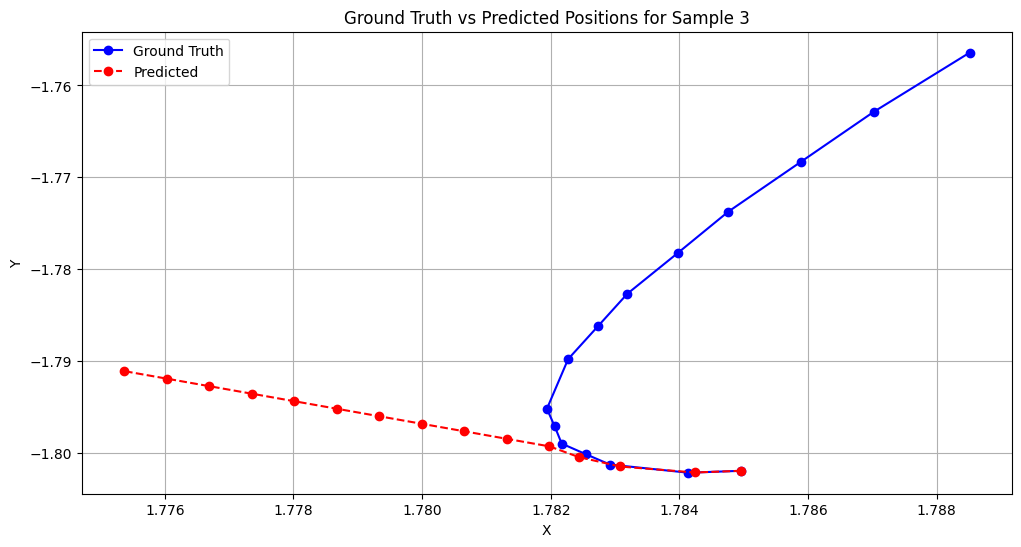

In [39]:
index = 7
predictions = run_kalman_filter_and_predict(batch_positions[0][index:])
plot_predictions(batch_positions[0][index:], predictions, sample_index=3)